In [1]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import matplotlib
import pylab as pl
from scipy.fftpack import rfft
import aifc
from IPython.display import Image
from PIL import Image
from keras.callbacks import ModelCheckpoint
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.font_manager import FontProperties

Watch train data

In [2]:
df = pd.read_csv('../data/data/train.csv')
print(df.head(-5))

             clip_name  label
0          train1.aiff      0
1          train2.aiff      0
2          train3.aiff      0
3          train4.aiff      0
4          train5.aiff      0
...                ...    ...
29990  train29991.aiff      1
29991  train29992.aiff      1
29992  train29993.aiff      0
29993  train29994.aiff      0
29994  train29995.aiff      0

[29995 rows x 2 columns]


Let's try to plot a simple spectrogram

In [3]:
def PlotSpecgram(P, freqs, bins):
    """Spectrogram"""
    Z = np.flipud(P) # flip rows so that top goes to bottom, bottom to top, etc.
    xextent = 0, np.amax(bins)
    xmin, xmax = xextent
    extent = xmin, xmax, freqs[0], freqs[-1]

    im = pl.imshow(Z, extent=extent)
    pl.axis('auto')
    pl.xlim([0.0, bins[-1]])
    pl.ylim([0, 1000])

In [4]:
whale_sample_file = '../data/data/train/train1.aiff'
whale_aiff = aifc.open(whale_sample_file,'r')
print("Channels:", whale_aiff.getnchannels()) 
print("Frames:", whale_aiff.getnframes())
print("Frame rate (frames per second):", whale_aiff.getframerate())

Channels: 1
Frames: 4000
Frame rate (frames per second): 2000


/var/folders/xw/04yvk1hx1tg55kxcyvtbggcm0000gn/T/ipykernel_2206/726627918.py:2: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  whale_array = np.fromstring(whale_strSig, np.short).byteswap()


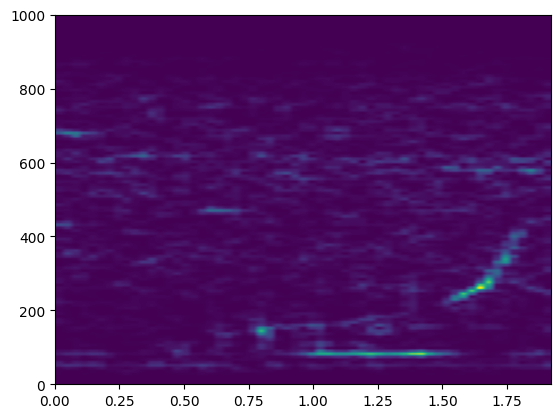

In [5]:
whale_strSig = whale_aiff.readframes(whale_aiff.getnframes())
whale_array = np.fromstring(whale_strSig, np.short).byteswap()
params = {'NFFT':256, 'Fs':2000, 'noverlap':192}
P, freqs, bins = mlab.specgram(whale_array, **params)
img = PlotSpecgram(P, freqs, bins)

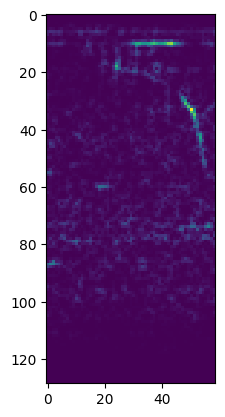

In [6]:
plt.imshow(P, interpolation='nearest')
plt.savefig("../images/data_ex", bbox_inches='tight')

In [7]:
# new_spect.shape

# new_spect *= 85.0/new_spect.max()

# Normalised [0,255] as integer: don't forget the parenthesis before astype(int)
# new_spect = (20.*(new_spect - np.min(new_spect))/np.ptp(new_spect))
# new_spect = 2.*(new_spect - np.min(new_spect))/np.ptp(new_spect)-1

# for i in range(len(new_spect)):
#     print(new_spect[i])

In [8]:
# img = np.zeros((129, 79, 3))
# img[:,:,0] = new_spect
# img[:,:,1] = new_spect
# img[:,:,2] = new_spect

# image = Image.fromarray(P, mode="L")
# # image.thumbnail((400, 400))
# image.save("test.jpg")
# print(image.mode)

Now we can plot and recognize others spectrograms and add a target for each of them

In [9]:
# Set path to directory with folders train and test
path_data = '../data/data/'
path_train_audio = '../data/data/train/'
path_target_train = '../data/data/train.csv'

In [10]:
# ReadAIFF function
def ReadAIFF(file):
# Reads the frames from the audio clip and returns the uncompressed data
    s = aifc.open(file,'r')
    nFrames = s.getnframes()
    strSig = s.readframes(nFrames)
    return np.fromstring(strSig, np.short).byteswap()

In [11]:
# Plot spectrogram function
def plot_spectrogram(filename, whale_flag):
# Plots a single spectrogram
    sound = ReadAIFF(filename)
    fig = plt.figure(figsize = (10,6), frameon=False)
    ax1 = fig.add_subplot(111)
    ax1.set_axis_off()
    # Setting spectrogram parameters
    my_cmap = matplotlib.cm.get_cmap('hsv_r')
    params = {'NFFT':256, 'Fs':2000, 'noverlap':192, 'cmap':my_cmap}
    plt.specgram(sound, **params)
    fig.savefig('test.png', bbox_inches='tight', pad_inches=0)
    # title0 = 'Spectrogram - Non-whale sound' if whale_flag == 0 else 'Spectrogram - Whale sound'
    # ax1.set_title(title0, fontsize = 16)
    # ax1.set_xlabel('Time (seconds)', fontsize = 12)
    # ax1.set_ylabel('Frequency (Hz)', fontsize = 12)
    # cbar = plt.colorbar()
    # cbar.set_label('Amplitude', fontsize = 12)

# # Plot non-whale sound    
# plot_spectrogram(path_data + 'train/train1.aiff', 0)
# Plot whale sound
# plot_spectrogram(path_data + 'train/train6.aiff', 1)

In [12]:
# Plot spectrograms side by side
def plot_sbs_spectrogram(filename_whale, filename_non_whale):
    whale = ReadAIFF(filename_whale)
    nonwhale = ReadAIFF(filename_non_whale)
    plt.figure(figsize = (14,4))
    ax1 = plt.subplot(121)
    my_cmap = matplotlib.cm.get_cmap('hsv_r')
    params = {'NFFT':256, 'Fs':2000, 'noverlap':192, 'cmap' : my_cmap}
    plt.specgram(whale, **params)
    ax1.set_title('Whale sound spectrogram', fontsize = 12)
    ax1.set_xlabel('Time (seconds)', fontsize = 12)
    ax1.set_ylabel('Frequency (Hz)', fontsize = 12)
    cbar = plt.colorbar()
    cbar.set_label('Amplitude', fontsize = 12)
    ax2 = plt.subplot(122)
    plt.specgram(nonwhale, **params)
    ax2.set_title('Non-whale sound spectrogram', fontsize = 12)
    ax2.set_xlabel('Time (seconds)', fontsize = 12)
    ax2.set_ylabel('Frequency (Hz)', fontsize = 12)
    cbar = plt.colorbar()
    cbar.set_label('Amplitude', fontsize = 12)
    plt.show()

# Compare several examples:
# plot_sbs_spectrogram(path_data + 'train/train6.aiff', path_data + 'train/train1.aiff')
# plot_sbs_spectrogram(path_data + 'train/train7.aiff', path_data + 'train/train2.aiff')
# plot_sbs_spectrogram(path_data + 'train/train9.aiff', path_data + 'train/train3.aiff')
# plot_sbs_spectrogram(path_data + 'train/train12.aiff', path_data + 'train/train4.aiff')

Create new data - from spectrograms to images

In [13]:
# Set path to directory with folders train and test
# path_data = '../data/data/'
# path_train_audio = '../data/data/train/'
path_train_img = '../data/data/train_img/'
# path_target_train = '../data/data/train.csv'

# def create_images_data(path_train_audio, path_train_img):
#     for i in range(len(df["clip_name"])):
#         whale_sample_file = path_train_audio + df["clip_name"][i]
#         sound = ReadAIFF(whale_sample_file)
#         fig = plt.figure(figsize = (10,6), frameon=False)
#         ax1 = fig.add_subplot(111)
#         ax1.set_axis_off()
#         # Setting spectrogram parameters
#         my_cmap = matplotlib.cm.get_cmap('hsv_r')
#         params = {'NFFT':256, 'Fs':2000, 'noverlap':192, 'cmap':my_cmap}
#         plt.specgram(sound, **params)
#         fig.savefig(path_train_img + df["clip_name"][i][:-5] + '.png', bbox_inches='tight', pad_inches=0)

# create_images_data(path_train_audio, path_train_img)

In [14]:
img = Image.open(path_train_img + df["clip_name"][0][:-5] + '.png')
img_arr = np.asarray(img)
img_arr.shape

(462, 775, 4)

Create train dataset

- train : 80%
- val : 10%
- test : 10%

In [15]:
# Set path to directory with folders train and test
path_data = '../data/data/'
path_train_audio = '../data/data/train/'
path_target_train = '../data/data/train.csv'
path_train_img = '../data/data/train_img/'

train_index = int(len(df["clip_name"]) * 0.8)
val_index = train_index + int(len(df["clip_name"]) * 0.1)
test_index = val_index + int(len(df["clip_name"]) * 0.1)

def create_dataset(train_index, val_index, test_index):
    # params = {'NFFT':256, 'Fs':2000, 'noverlap':192, 'sides':'twosided'}
    # spect_zeros = np.zeros((256, 80))

    x_train = []
    y_train = []

    x_val = []
    y_val = []
    
    x_test = []
    y_test = []
    for i in range(len(df["clip_name"])):
        rgba_image = Image.open(path_train_img + df["clip_name"][i][:-5] + '.png')
        img = rgba_image.convert('RGB')
        img_arr = np.asarray(img)

        # whale_sample_file = path_train_audio + df["clip_name"][i]
        # whale_aiff = aifc.open(whale_sample_file, 'r')
        # whale_strSig = whale_aiff.readframes(whale_aiff.getnframes())
        # whale_array = np.fromstring(whale_strSig, np.short).byteswap()
        # P, freqs, bins = mlab.specgram(whale_array, **params)

        # cont_spect = np.concatenate((spect_zeros, P), axis=1)
        # cont_spect = np.concatenate((cont_spect, spect_zeros), axis=1)
        # spect = cont_spect.reshape(146, 128, 3)
        if i < train_index:
            x_train.append(img_arr)
            y_train.append(df["label"][i])
        elif i < val_index:
            x_val.append(img_arr)
            y_val.append(df["label"][i])
        else:
            x_test.append(img_arr)
            y_test.append(df["label"][i])
    return np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test)

In [16]:
# batch_size = 32

x_train, y_train, x_val, y_val, x_test, y_test = create_dataset(train_index, val_index, test_index)

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_data = train_data.cache().batch(batch_size).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# val_data = val_data.batch(batch_size).repeat()

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
# test_data = test_data.batch(batch_size).repeat()

In [17]:
x_train.shape

(24000, 462, 775, 3)

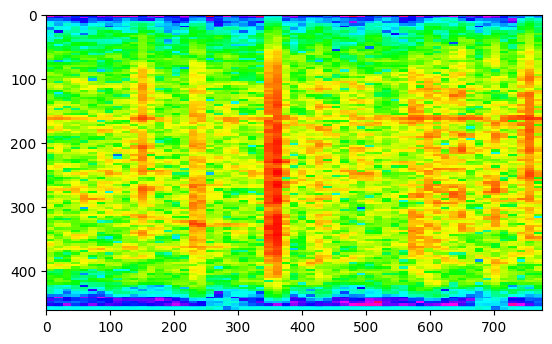

In [18]:
plt.imshow(x_train[9], interpolation='nearest')

Prepare data for NN

In [19]:
size = (120, 120)

train_ds = train_data.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = val_data.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_data.map(lambda x, y: (tf.image.resize(x, size), y))

In [20]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [21]:
# import numpy as np

# for images, labels in train_ds.take(1):
#     plt.figure(figsize=(10, 10))
#     first_image = images[0]
#     plt.imshow(first_image.numpy().astype("int32"))
#     plt.title(int(labels[0]))
#     plt.axis("off")

In [22]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

### Xception

In [27]:
# https://keras.io/guides/transfer_learning/

Xception_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(120, 120, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [28]:
# Freeze the base_model
Xception_model.trainable = False

In [29]:
inputs = keras.Input(shape=(120, 120, 3))
x = inputs
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

In [30]:
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = Xception_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(200)(x)
outputs = keras.layers.Dense(1)(x)
model_x = keras.Model(inputs, outputs)

model_x.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 120, 120, 3)       0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 200)               409800    
                                                           

In [31]:
# weights_file_x = 'xception_weights_1.h5'
# callback_x = ModelCheckpoint(weights_file_x, mode='max', save_best_only=True)

# model_x.load_weights(weights_file_x)

model_x.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
# history_x1 = model_x.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[callback_x])
history_x1 = model_x.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20


2023-03-10 15:35:38.756234: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


750/750 [==============================] - 202s 268ms/step - loss: 0.3990 - binary_accuracy: 0.8320 - val_loss: 1.0621 - val_binary_accuracy: 0.5593
Epoch 2/20
750/750 [==============================] - 205s 273ms/step - loss: 0.3533 - binary_accuracy: 0.8332 - val_loss: 1.1216 - val_binary_accuracy: 0.5567
Epoch 3/20
750/750 [==============================] - 207s 276ms/step - loss: 0.3454 - binary_accuracy: 0.8378 - val_loss: 1.1704 - val_binary_accuracy: 0.5553
Epoch 4/20
 77/750 [==>...........................] - ETA: 2:46 - loss: 0.2031 - binary_accuracy: 0.9140

KeyboardInterrupt: 

In [54]:
weights_file_x2 = 'xception_weights_2.h5'
callback_x2 = ModelCheckpoint(weights_file_x2, mode='max', save_best_only=True)

# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
Xception_model.trainable = True
model_x.summary()

model_x.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
history_x2 = model_x.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[callback_x2])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 200)               409800    
                                                           

### InceptionResNetV2

In [55]:
ResNet_model = keras.applications.InceptionResNetV2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(200, 200, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
    
ResNet_model.trainable = False

In [56]:
inputs = keras.Input(shape=(200, 200, 3))
x = inputs
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

In [57]:
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = ResNet_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(200, activation='relu')(x)
outputs = keras.layers.Dense(1)(x)
model_v = keras.Model(inputs, outputs)

model_v.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_5 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 4, 4, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_5   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 1536)              0         
                                                                 
 dense_10 (Dense)            (None, 200)               3074

In [58]:
weights_file_v = 'vgg_weights_1.h5'
callback_v = ModelCheckpoint(weights_file_v, mode='max', save_best_only=True)

model_v.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
history_v1 = model_v.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[callback_v])

Epoch 1/20
750/750 [==============================] - 598s 791ms/step - loss: 0.5213 - binary_accuracy: 0.7769 - val_loss: 0.7267 - val_binary_accuracy: 0.5500
Epoch 2/20
750/750 [==============================] - 604s 805ms/step - loss: 0.5017 - binary_accuracy: 0.7774 - val_loss: 0.7666 - val_binary_accuracy: 0.5500
Epoch 3/20
750/750 [==============================] - 616s 821ms/step - loss: 0.5075 - binary_accuracy: 0.7774 - val_loss: 0.7762 - val_binary_accuracy: 0.5500
Epoch 4/20
750/750 [==============================] - 614s 819ms/step - loss: 0.5088 - binary_accuracy: 0.7774 - val_loss: 0.7686 - val_binary_accuracy: 0.5500
Epoch 5/20
750/750 [==============================] - 601s 802ms/step - loss: 0.5107 - binary_accuracy: 0.7774 - val_loss: 0.7790 - val_binary_accuracy: 0.5500
Epoch 6/20
750/750 [==============================] - 597s 796ms/step - loss: 0.5115 - binary_accuracy: 0.7774 - val_loss: 0.6905 - val_binary_accuracy: 0.5500
Epoch 7/20
750/750 [====================

In [59]:
weights_file_v2 = 'vgg_weights_2.h5'
callback_v2 = ModelCheckpoint(weights_file_v2, mode='max', save_best_only=True)

# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
ResNet_model.trainable = True
model_v.summary()

model_v.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
history_v2 = model_v.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[callback_v2])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_5 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 4, 4, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_5   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 1536)              0         
                                                                 
 dense_10 (Dense)            (None, 200)               3074

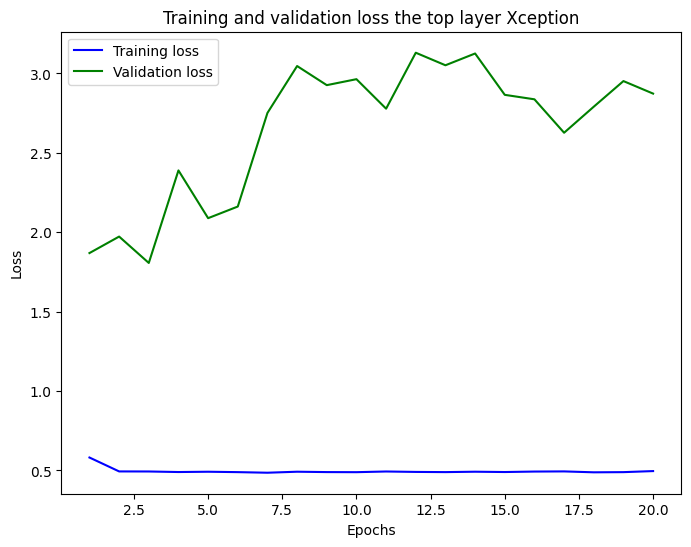

In [60]:


loss = history_x1.history['loss']
val_loss = history_x1.history['val_loss']
epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'g', label='Validation loss')
# # plt.title('Training and validation loss')
# # plt.ylim(0, 0.3)
# plt.legend()
# plt.show()

pdf = PdfPages("../images/loss_x1.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(8, 5))
# ax.axis('equal')
ax.plot(epochs, loss, 'b', label='Training loss')
ax.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss the top layer Xception')
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

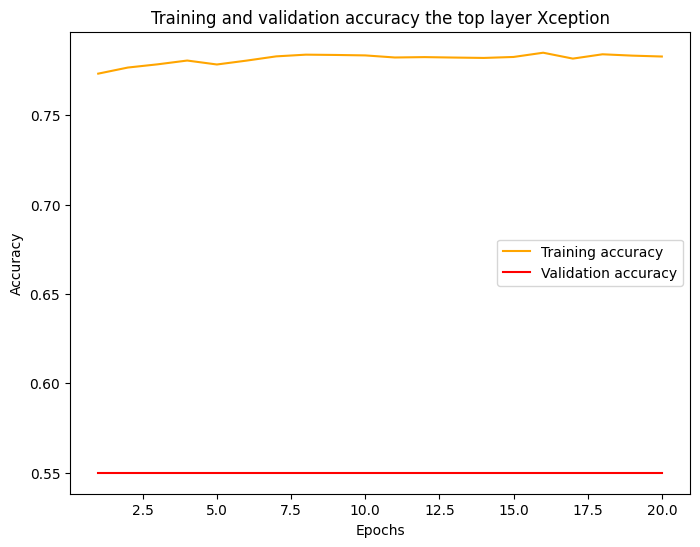

In [73]:
loss = history_x1.history['binary_accuracy']
val_loss = history_x1.history['val_binary_accuracy']
epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'g', label='Validation loss')
# # plt.title('Training and validation loss')
# # plt.ylim(0, 0.3)
# plt.legend()
# plt.show()

pdf = PdfPages("../images/accuracy_x1.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(8, 5))
# ax.axis('equal')
ax.plot(epochs, loss, color = 'orange', label='Training accuracy')
ax.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy the top layer Xception')
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

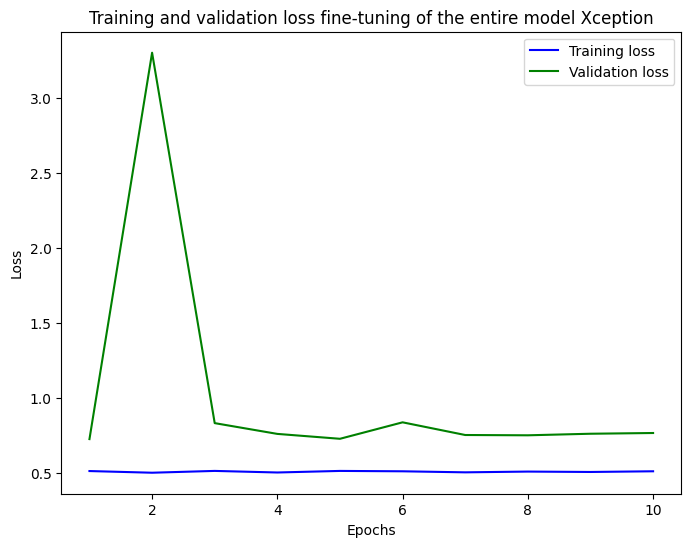

In [62]:
loss = history_x2.history['loss']
val_loss = history_x2.history['val_loss']
epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'g', label='Validation loss')
# # plt.title('Training and validation loss')
# # plt.ylim(0, 0.3)
# plt.legend()
# plt.show()

pdf = PdfPages("../images/loss_x2.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(8, 5))
# ax.axis('equal')
ax.plot(epochs, loss, 'b', label='Training loss')
ax.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss fine-tuning of the entire model Xception')
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

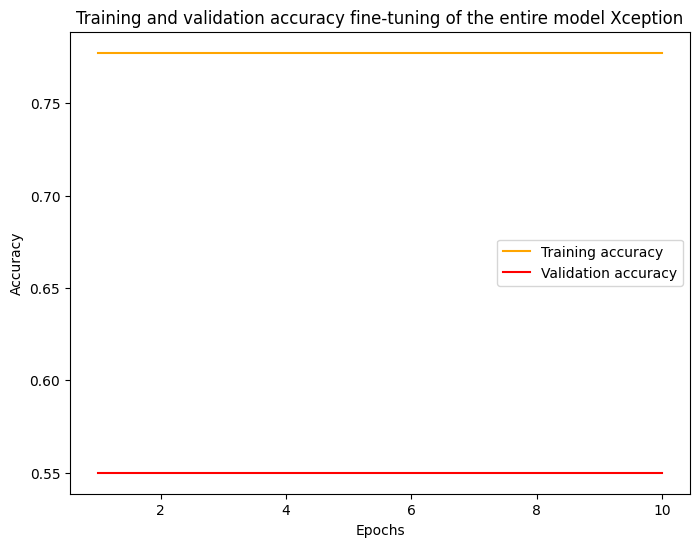

In [72]:
loss = history_x2.history['binary_accuracy']
val_loss = history_x2.history['val_binary_accuracy']
epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'g', label='Validation loss')
# # plt.title('Training and validation loss')
# # plt.ylim(0, 0.3)
# plt.legend()
# plt.show()

pdf = PdfPages("../images/accuracy_x2.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(8, 5))
# ax.axis('equal')
ax.plot(epochs, loss, color = 'orange', label='Training accuracy')
ax.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy fine-tuning of the entire model Xception')
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

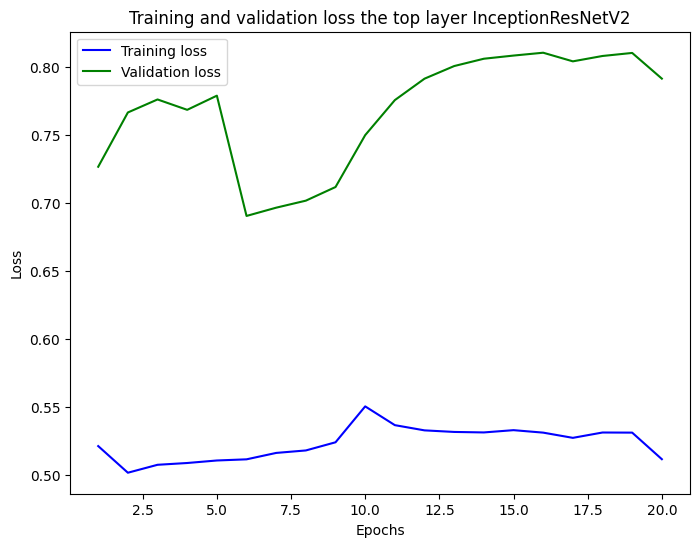

In [64]:
loss = history_v1.history['loss']
val_loss = history_v1.history['val_loss']
epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'g', label='Validation loss')
# # plt.title('Training and validation loss')
# # plt.ylim(0, 0.3)
# plt.legend()
# plt.show()

pdf = PdfPages("../images/loss_v1.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(8, 5))
# ax.axis('equal')
ax.plot(epochs, loss, 'b', label='Training loss')
ax.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss the top layer InceptionResNetV2')
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

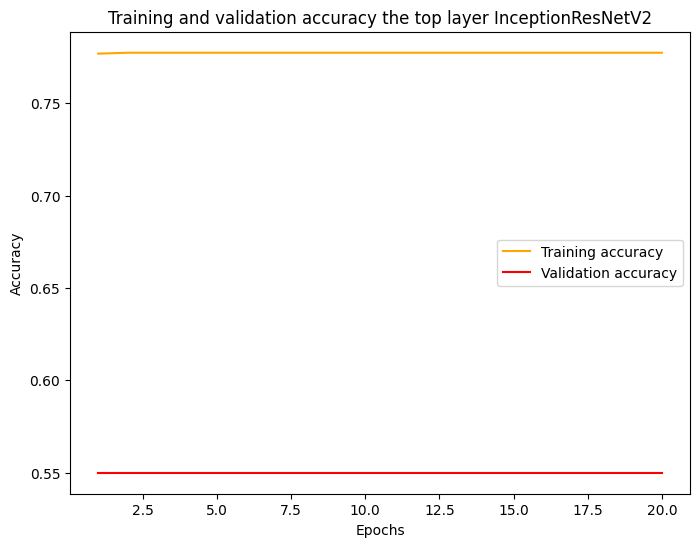

In [71]:
loss = history_v1.history['binary_accuracy']
val_loss = history_v1.history['val_binary_accuracy']
epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'g', label='Validation loss')
# # plt.title('Training and validation loss')
# # plt.ylim(0, 0.3)
# plt.legend()
# plt.show()

pdf = PdfPages("../images/accuracy_v1.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(8, 5))
# ax.axis('equal')
ax.plot(epochs, loss, color = 'orange', label='Training accuracy')
ax.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy the top layer InceptionResNetV2')
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

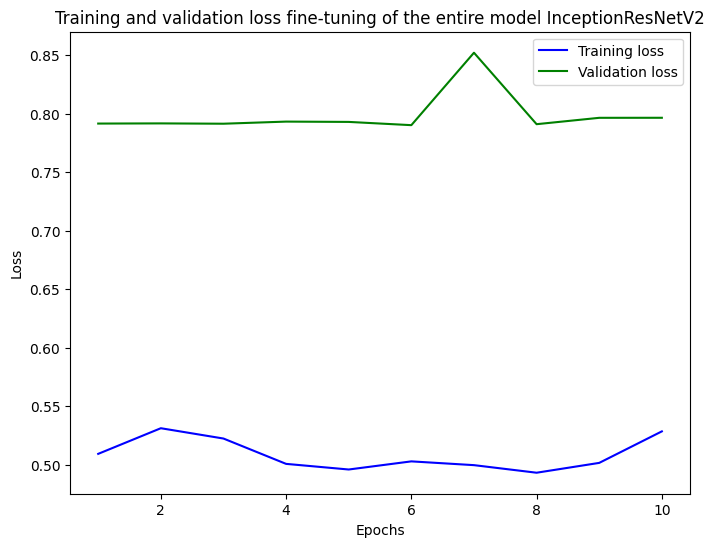

In [66]:
loss = history_v2.history['loss']
val_loss = history_v2.history['val_loss']
epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'g', label='Validation loss')
# # plt.title('Training and validation loss')
# # plt.ylim(0, 0.3)
# plt.legend()
# plt.show()

pdf = PdfPages("../images/loss_v2.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(8, 5))
# ax.axis('equal')
ax.plot(epochs, loss, 'b', label='Training loss')
ax.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss fine-tuning of the entire model InceptionResNetV2')
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

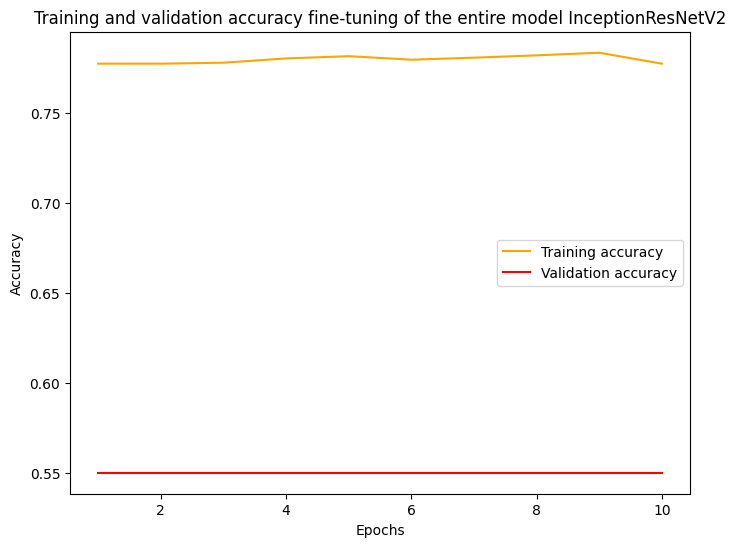

In [70]:
loss = history_v2.history['binary_accuracy']
val_loss = history_v2.history['val_binary_accuracy']
epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'g', label='Validation loss')
# # plt.title('Training and validation loss')
# # plt.ylim(0, 0.3)
# plt.legend()
# plt.show()

pdf = PdfPages("../images/accuracy_v2.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(8, 5))
# ax.axis('equal')
ax.plot(epochs, loss, color = 'orange', label='Training accuracy')
ax.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy fine-tuning of the entire model InceptionResNetV2')
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

In [77]:
score_x = model_x.evaluate(test_ds, verbose=0)
print("Xception test loss:", score_x[0])
print("Xception test accuracy:", score_x[1])

Xception test loss: 0.4244491755962372
Xception test accuracy: 0.8886666893959045


In [76]:
score_v = model_v.evaluate(test_ds, verbose=0)
print("InceptionResNetV2 test loss:", score_v[0])
print("InceptionResNetV2 test accuracy:", score_v[1])

InceptionResNetV2 test loss: 0.4008150100708008
Test accuracy: 0.8886666893959045


### Let build the simple CNN

In [26]:
# Set path to directory with folders train and test
path_data = '../data/data/'
path_train_audio = '../data/data/train/'
path_target_train = '../data/data/train.csv'
path_train_img = '../data/data/train_img/'

train_index = int(len(df["clip_name"]) * 0.8)
val_index = train_index + int(len(df["clip_name"]) * 0.1)
test_index = val_index + int(len(df["clip_name"]) * 0.1)

def create_dataset_simple(train_index, val_index, test_index):
    params = {'NFFT':256, 'Fs':2000, 'noverlap':192}

    x_train = []
    y_train = []

    x_val = []
    y_val = []
    
    x_test = []
    y_test = []
    for i in range(len(df["clip_name"])):
        whale_sample_file = path_train_audio + df["clip_name"][i]
        whale_aiff = aifc.open(whale_sample_file, 'r')
        whale_strSig = whale_aiff.readframes(whale_aiff.getnframes())
        whale_array = np.fromstring(whale_strSig, np.short).byteswap()
        spect, freqs, bins = mlab.specgram(whale_array, **params)

        if i < train_index:
            x_train.append(spect)
            y_train.append(df["label"][i])
        elif i < val_index:
            x_val.append(spect)
            y_val.append(df["label"][i])
        else:
            x_test.append(spect)
            y_test.append(df["label"][i])
    return np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test)

In [27]:
x_train, y_train, x_val, y_val, x_test, y_test = create_dataset_simple(train_index, val_index, test_index)

/var/folders/xw/04yvk1hx1tg55kxcyvtbggcm0000gn/T/ipykernel_2510/753473725.py:26: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  whale_array = np.fromstring(whale_strSig, np.short).byteswap()


In [28]:
#reshape data to create dataset
x_train = x_train.reshape(24000,129,59,1)
y_train = y_train.reshape(24000,1)

x_val = x_val.reshape(3000,129,59,1)
y_val = y_val.reshape(3000,1)

x_test = x_test.reshape(3000,129,59,1)
y_test = y_test.reshape(3000,1)

In [29]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_data = train_data.cache().batch(batch_size).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# val_data = val_data.batch(batch_size).repeat()

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
# test_data = test_data.batch(batch_size).repeat()

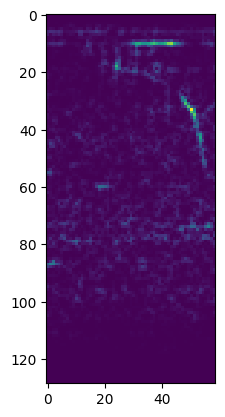

In [30]:
plt.imshow(x_train[0], interpolation='nearest')

In [31]:
train_ds = train_data
validation_ds = val_data
test_ds = test_data

In [32]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, ConvLSTM2D

#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(129,59,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Conv2D(16, kernel_size=3, activation='relu'))
# model.add(ConvLSTM2D(24, kernel_size=3))
model.add(Flatten())
model.add(Dense(1, activation='softmax'))

#compile model using accuracy to measure model performance
model.compile(optimizer='adam',
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()])

#train the model
history = model.fit(train_ds, validation_data=validation_ds, epochs=3)
# history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10)

Epoch 1/3
  1/750 [..............................] - ETA: 2:26 - loss: 605.5082 - binary_accuracy: 0.2188

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 [==============================] - 5s 6ms/step - loss: 127.0116 - binary_accuracy: 0.2226 - val_loss: 34.5605 - val_binary_accuracy: 0.4500
Epoch 2/3
750/750 [==============================] - 4s 6ms/step - loss: 16.8583 - binary_accuracy: 0.2226 - val_loss: 5.0673 - val_binary_accuracy: 0.4500
Epoch 3/3
750/750 [==============================] - 4s 6ms/step - loss: 2.7161 - binary_accuracy: 0.2226 - val_loss: 4.8090 - val_binary_accuracy: 0.4500


In [142]:
import pydot

tf.keras.utils.plot_model(model, to_file="../images/simple_model.pdf", show_shapes=True)

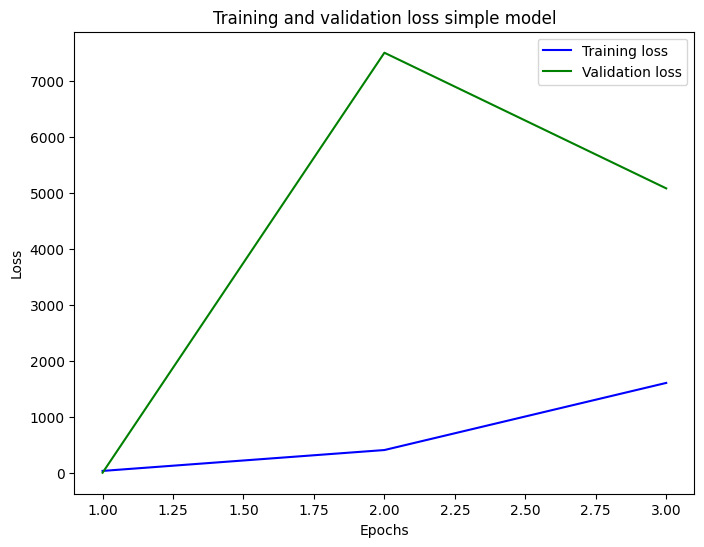

In [40]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'g', label='Validation loss')
# # plt.title('Training and validation loss')
# # plt.ylim(0, 0.3)
# plt.legend()
# plt.show()

pdf = PdfPages("../images/loss_simple.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(8, 5))
# ax.axis('equal')
ax.plot(epochs, loss, 'b', label='Training loss')
ax.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss simple model')
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

In [37]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'g', label='Validation loss')
# # plt.title('Training and validation loss')
# # plt.ylim(0, 0.3)
# plt.legend()
# plt.show()

pdf = PdfPages("../images/accuracy_simple.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(8, 5))
# ax.axis('equal')
ax.plot(epochs, loss, color='orange', label='Training accuracy')
ax.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy simple model')
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

KeyError: 'accuracy'

In [43]:
score = model.evaluate(test_ds, verbose=0)
print("Simple CNN test loss:", score[0])
print("Simple CNN test accuracy:", score[1])

Simple CNN test loss: 1.226961612701416
Simple CNN test accuracy: 0.11133333295583725


Let try to train the same network, but on the PNG images

In [113]:
weights_file_simple = 'weights_simple.h5'
callback_simple = ModelCheckpoint(weights_file_simple, mode='max', save_best_only=True)

#create model
model_png = Sequential()
#add model layers
model_png.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(200,200,3)))
model_png.add(Conv2D(32, kernel_size=3, activation='relu'))
model_png.add(Conv2D(16, kernel_size=3, activation='relu'))
# model.add(ConvLSTM2D(24, kernel_size=3))
model_png.add(Flatten())
model_png.add(Dense(1, activation='softmax'))

#compile model using accuracy to measure model performance
model_png.compile(optimizer='adam',
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()])

#train the model
history_png = model_png.fit(train_ds, validation_data=validation_ds, epochs=10, callbacks=[callback_simple])

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 [==============================] - 609s 810ms/step - loss: 9.2413 - binary_accuracy: 0.2226 - val_loss: 7.5820 - val_binary_accuracy: 0.4500
Epoch 2/10
750/750 [==============================] - 596s 794ms/step - loss: 0.5045 - binary_accuracy: 0.2226 - val_loss: 0.7662 - val_binary_accuracy: 0.4500
Epoch 3/10
750/750 [==============================] - 601s 801ms/step - loss: 0.4917 - binary_accuracy: 0.2226 - val_loss: 2.2981 - val_binary_accuracy: 0.4500
Epoch 4/10
750/750 [==============================] - 603s 804ms/step - loss: 0.5071 - binary_accuracy: 0.2226 - val_loss: 0.6893 - val_binary_accuracy: 0.4500
Epoch 5/10
750/750 [==============================] - 603s 805ms/step - loss: 0.5793 - binary_accuracy: 0.2226 - val_loss: 0.7247 - val_binary_accuracy: 0.4500
Epoch 6/10
750/750 [==============================] - 603s 804ms/step - loss: 0.5443 - binary_accuracy: 0.2226 - val_loss: 0.7582 - val_binary_accuracy: 0.4500
Epoch 7/10
750/750 [==============================]

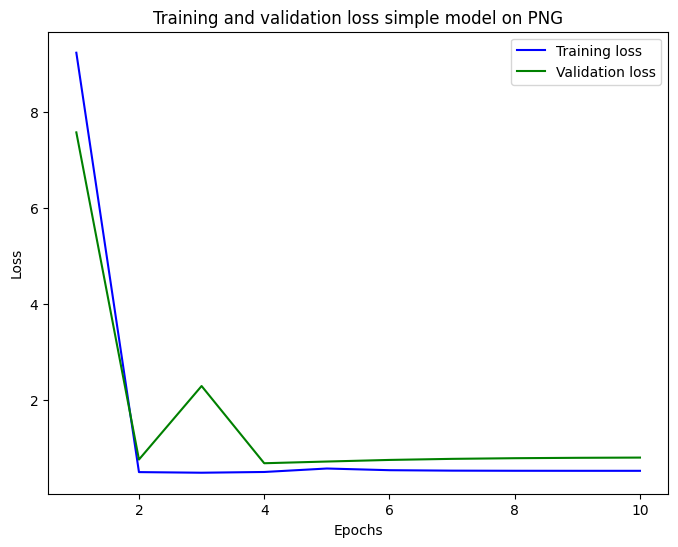

In [114]:
loss = history_png.history['loss']
val_loss = history_png.history['val_loss']
epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'g', label='Validation loss')
# # plt.title('Training and validation loss')
# # plt.ylim(0, 0.3)
# plt.legend()
# plt.show()

pdf = PdfPages("../images/loss_simple_png.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(8, 5))
# ax.axis('equal')
ax.plot(epochs, loss, 'b', label='Training loss')
ax.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss simple model on PNG')
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

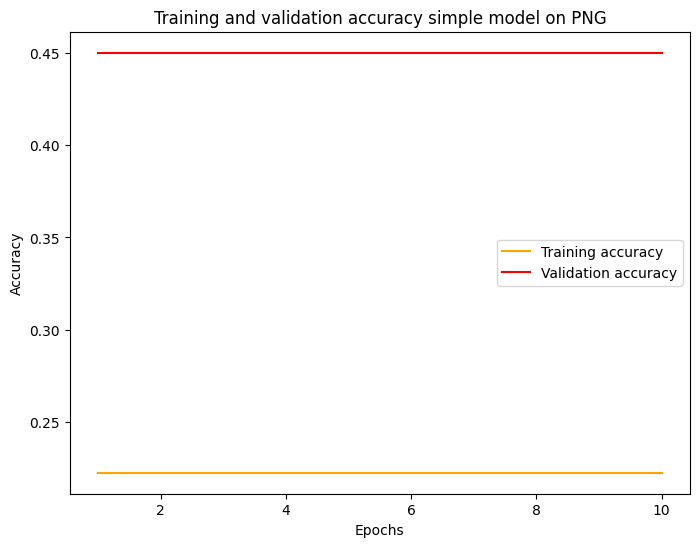

In [117]:
loss = history_png.history['binary_accuracy']
val_loss = history_png.history['val_binary_accuracy']
epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'g', label='Validation loss')
# # plt.title('Training and validation loss')
# # plt.ylim(0, 0.3)
# plt.legend()
# plt.show()

pdf = PdfPages("../images/accuracy_simple_png.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(8, 5))
# ax.axis('equal')
ax.plot(epochs, loss, color='orange', label='Training accuracy')
ax.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy simple model on PNG')
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

In [118]:
score = model_png.evaluate(test_ds, verbose=0)
print("Simple CNN test loss:", score[0])
print("Simple CNN test accuracy:", score[1])

Simple CNN test loss: 0.3948439061641693
Simple CNN test accuracy: 0.11133333295583725


In [137]:
sum = 0
# for i in range(len(x_test)):
for i, sample in enumerate(test_ds):
    predict = model_png.predict(sample[0])
    for j in range(len(predict)):
        if predict[j] == 1: predict[j] = 0
        else: predict[j] = 1

    for j in range(len(predict)):
        if predict[j] == y_test[i*32 + j]: sum += 1

print("Accuracy:", sum / np.sum(y_test))

1/1 [==============================] - 0s 137ms/step
Accurecy: 7.982035928143713


In [135]:
y_test.shape

(3000,)

<TakeDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>